In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import torch.nn.functional as F
import torchvision.transforms as transforms

In [4]:
# this allows pytorch to use a GPU, if one is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
device

device(type='cpu')

In [6]:
data = np.load('./pathmnist.npz')

In [7]:
train_data = data['train_images']
train_labels = data['train_labels']
val_data = data['val_images']
val_labels = data['val_labels']
test_data = data['test_images']
test_labels = data['test_labels']

Assigning each of the training, validation and test sets to their own array

In [8]:
label_dict = {
            0: "adipose",
            1: "background",
            2: "debris",
            3: "lymphocytes",
            4: "mucus",
            5: "smooth muscle",
            6: "normal colon mucosa",
            7: "cancer-associated stroma",
            8: "colorectal adenocarcinoma epithelium"
        }

In [9]:
train_data.shape

(89996, 28, 28, 3)

Each image is of size 28x28x3. The 28 corresponds to the height and width of the image in pixels. There are 3 channels, corresponding to the amount of Red, Green, and Blue in each pixel.

# Data format for Pytorch

In [10]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [11]:
# Converting our data into tensors

def torch_format_data(data, data_name, label_name, device):
    t_data = data[data_name]
    t_data = t_data.astype(np.float32)
    t_data = np.mean(t_data, -1)/256
    mean = t_data.mean()               # Calculating mean
    std = t_data.std()                 # Calculating standard deviation
    t_data = np.expand_dims(t_data,1)
    labels = data[label_name]
    labels = labels.squeeze(1)
    
    t_data = torch.tensor(t_data)
    labels = torch.tensor(labels, dtype=torch.long, device=device)
    dataset = torch.utils.data.TensorDataset(t_data, labels)
    return dataset,mean,std

Along with converting the data into tensors we have also converted the image from 3 channels to 1 channel.

In [12]:
train_set,train_mean,train_std = torch_format_data(data, 'train_images', 'train_labels', device)
validation_set,validation_mean,validation_std = torch_format_data(data, 'val_images', 'val_labels', device)
test_set,test_mean,test_std = torch_format_data(data, 'test_images', 'test_labels', device)

For preprocessing of the image (normalization) we have calculated the mean and standard deviation which would be later used in the ImageClassificationBase class.

# Data Visualization

In [13]:
img, label = train_set[0]    # Accessing the image and label

In [14]:
def show_example(img, label):
    print(label.item())
    print(f'Label: "{label_dict[label.item()]}"')
    plt.imshow(img.permute(1, 2, 0))       # Changing the tensor dimension for visualization
    print('Image shape:', img.shape)

Creating a helper function to display an image and its label.

0
Label: "adipose"
Image shape: torch.Size([1, 28, 28])


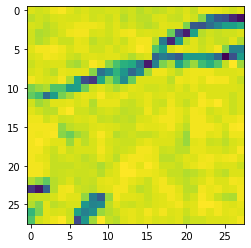

In [15]:
show_example(*train_set[0])

Thus we have visualised the image along with its label and dimensions.

In [16]:
batch_size= 100
train_dl = DataLoader(train_set, batch_size, shuffle=True, num_workers=0)
val_dl = DataLoader(validation_set, batch_size*2, num_workers=0)

We create data loaders for training and validation, to load the data in batches. Each time the following code is run, we get a different bach, since the sampler shuffles the indices before creating batches. 

# Defining the model (Convolutional Neural Network)

Defining the model by extending an ImageClassificationBase class which contains helper methods for training & validation.

In [17]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        transform = transforms.Compose([transforms.Normalize(train_mean, train_std)]) # Normalization
        images = transform(images)
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        transform = transforms.Compose([transforms.Normalize(train_mean, train_std)]) # Normalization
        images = transform(images)
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

For the image classification the loss that we use is cross entropy and the metric used for evaluation is accuracy metric. Over here we are extending the nn.module class and capture all of the image classification related code in a single base class called ImageClassificationBase(). For performing image classification this base class would act as the starting point. 

In the training_step() function from the batch we get images and labels and perform preprocessing on the images. We pass these images to the model and get a output and finally we calculate loss using cross entropy and return it. Similarly for validation_step() function we repeat the same steps and calculate accuracy then return validation loss and validation accuracy.

The validation_epoch_end() function is going to take the losses and accuracies from all different batches of validation data and combine them taking the mean and return a single validation loss and validation accuracy for the validation set. 

The epoch_end() function would take the results of the epoch and print them out. The accuracy() function is used to calculate the accuracy of the predictions.

In [18]:
class CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5,stride = 1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),   
            
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),    

 
            nn.Flatten(), 
            nn.Linear(32 * 7 * 7, 9))
             
    def forward(self, xb):
         
        return self.network(xb)

Here we are extending the ImageClassificationBase class to create the CnnModel. We use nn.Sequential to chain the layers and activations functions into a single network architecture. Using nn.Sequential we pass the input through each of the layer. Here the output of the first convolutional layer is passed to second convolutional layer and finally to the flattened layer. In the first layer it takes 1 channel image and gives 16 convolution filters (out_channels) which are the feature maps, the kernel is used to find various patterns in the input image and these patterns are then dubbed to feature maps. These feature maps are then passed to Relu activation function to capture non-linearity and then we finally perform max-pooling for extracting dominant features. Since first layer captures low-level features the second layer would help us in capturing high- level features. 

The output feature maps from the second layer are flattened to a vector using nn.Flatten() and passed to the fully connected linear layer, this is done because at the end we want a vector of size 9 since we have 9 tissue types. Each element represents the probability that an image belongs to a particular tissue type. 

The function, forward, describes how the whole network is put together from its component layers.

In [19]:
model = CnnModel()    # Instantiating our object
model                 # Displaying the model

CnnModel(
  (network): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1568, out_features=9, bias=True)
  )
)

In [20]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([100, 1, 28, 28])
out.shape: torch.Size([100, 9])
out[0]: tensor([ 0.0202, -0.0697,  0.1192, -0.1159, -0.0790,  0.0157,  0.0072, -0.0158,
         0.0830], grad_fn=<SelectBackward>)


Here we are checking the expected output on the batch of training data. 'out.shape' indicates a batch size of 100 and single vector of size 9 which is our required output. out[0] gives 9 outputs which are the scores given by the model for each tissue type. The highest score is '0.13141' at the third index place which represents "lymphocytes". Thus the model predicts this image to be of tissue type "lymphocytes". 

In [21]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [22]:
device = get_default_device()
device

device(type='cpu')

In [23]:
train_dl2 = DeviceDataLoader(train_dl, device)
val_dl2 = DeviceDataLoader(val_dl, device)
to_device(model, device);

We can now wrap our training and validation data loaders using DeviceDataLoader for automatically transferring batches of data to the GPU, and use 'to_device' to move our model to the GPU.

# Training the Model

In [24]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()              # backpropagation, compute gradients
            optimizer.step()             # apply gradients  
            optimizer.zero_grad()        # clear gradients for this training step
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

We have defined two functions: fit and evaluate to train the model using gradient descent and evaluate its performance on the validation set.

The function fit is going to perform gradient descent, for given number of epochs it's going to loop over the number of epochs and in each epoch there is a training phase and a validation phase. In the training phase we get batches of data from the training data loader, we call the training step function and it returns the loss for the passed batches of data. We perform gradient descent using an optimizer and the optimization function here is either Stochastic Gradient Descent or Adam. The optimizer basically takes the model parameters which the weights and biases of all the layers and also it takes the learning rate and then updates the weights and baises using the graients that have been calculated when we called loss.backward(). We are also keeping track of the batch- wise training losses. 

We use decorator @torch.no_grad() at the evaluate() function so that it will not compute any gradients. In the function we calculate the validation loss and validation accuracy for each batch and lastly we average out the validation loss and validation accuracy across the batches of data and return a single output. 

In the result we get the validation loss and validation accuracy. Then we are calculating the average training loss for the entire epoch. We then call model.epoch_end() and it is going to print the epoch number, training loss, validation loss and validation accuracy. We take the result and place it into history list and return it so that we have the entire history of the model as the output of the fit function. 

In [25]:
# model = to_device(CnnModel(), device) 

Before training, we instantiate the model once again and see how it performs on the validation set with the initial set of parameters.

We are moving the model to the device

In [26]:
evaluate(model, val_dl2)

{'val_loss': 2.2080914974212646, 'val_acc': 0.12872548401355743}

We evaluating the model on the validation dataloader and we get very low accuracy because the weights inside the kernels for performing convolution are initialised randomly and we get a random result. As we begin training the model weights would change and we would get better results.

In [27]:
# Hyperparameters for the Model

num_epochs = 10
opt_func = [torch.optim.Adam, torch.optim.SGD]
lr = 0.001

In [28]:
history = fit(num_epochs, lr, model, train_dl2, val_dl2, torch.optim.Adam)

Epoch [0], train_loss: 1.0746, val_loss: 0.9360, val_acc: 0.6573
Epoch [1], train_loss: 0.8012, val_loss: 0.7439, val_acc: 0.7352
Epoch [2], train_loss: 0.6991, val_loss: 0.6759, val_acc: 0.7585
Epoch [3], train_loss: 0.6228, val_loss: 0.6528, val_acc: 0.7683
Epoch [4], train_loss: 0.5642, val_loss: 0.6386, val_acc: 0.7738
Epoch [5], train_loss: 0.5212, val_loss: 0.5773, val_acc: 0.7924
Epoch [6], train_loss: 0.4868, val_loss: 0.5367, val_acc: 0.8128
Epoch [7], train_loss: 0.4690, val_loss: 0.5679, val_acc: 0.8004
Epoch [8], train_loss: 0.4458, val_loss: 0.5308, val_acc: 0.8108
Epoch [9], train_loss: 0.4278, val_loss: 0.5418, val_acc: 0.8142


We perform training by calling the fit() function and passing the required parameters. The results are stored
in history as a dictionary

In [31]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history] # getting validation accuracies from each epoch in history
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

We plot the valdation set accuracies to study how the model improves over time.



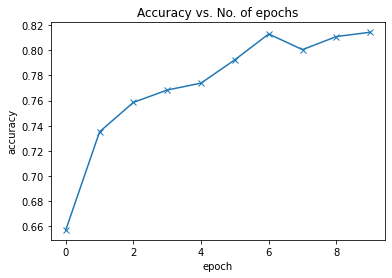

In [32]:
plot_accuracies(history)

In [33]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

We plot the training and validation losses to study the trend.

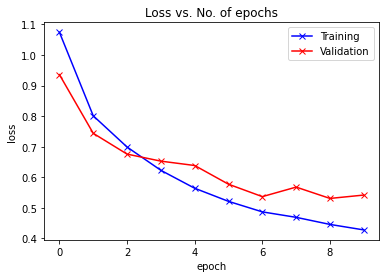

In [34]:
plot_losses(history)

# Testing

In [35]:
test_loader = DeviceDataLoader(DataLoader(test_set, batch_size*2), device) # testing using test_dataset
result = evaluate(model, test_loader)
result

{'val_loss': 0.634674072265625, 'val_acc': 0.7810803055763245}

We look at the overall loss and accuracy of the model on the test set.

# Testing with Individual Images

In [36]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return label_dict[label.item()]

Label: "colorectal adenocarcinoma epithelium" , Predicted: colorectal adenocarcinoma epithelium


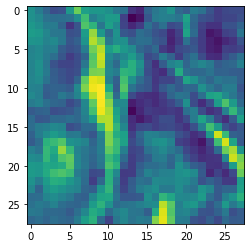

In [37]:
img, label = test_set[0]
plt.imshow(img.permute(1, 2, 0))
print(f'Label: "{label_dict[label.item()]}"', ', Predicted:', predict_image(img, model))

The input image is predicted accurately

# Logistic Regression

In [38]:
import torch.nn as nn

input_size = 28*28
num_classes = 9

#Logistic regression model
model_ = nn.Linear(input_size, num_classes)

Since nn.Linear expects each training example to be a vector, each 1x28x28 image tensor is flattened into a vector of size 784 (28*28) before being passed into the model.

The output for each image is a vector of size 9, with each element signifying the probability of a particular target label (i.e., 0 to 8). The predicted label for an image is simply the one with the highest logists score.

# Training the model

In [39]:
def fit2(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results
    
    for epoch in range(epochs):
        
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate2(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [40]:
def evaluate2(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [41]:
class TypeModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        transform = transforms.Compose([transforms.Normalize(train_mean, train_std)]) # Normalization
        images = transform(images)
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        transform = transforms.Compose([transforms.Normalize(train_mean, train_std)]) # Normalization
        images = transform(images)
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model2 = TypeModel()

In [42]:
to_device(model2, device)

TypeModel(
  (linear): Linear(in_features=784, out_features=9, bias=True)
)

In [43]:
result0 = evaluate2(model2, val_dl2)
result0

{'val_loss': 2.4173715114593506, 'val_acc': 0.10421568900346756}

In [44]:
history2 = fit2(10, 0.001, model2, train_dl2, val_dl2)

Epoch [0], val_loss: 1.9898, val_acc: 0.3087
Epoch [1], val_loss: 1.9643, val_acc: 0.3039
Epoch [2], val_loss: 1.9678, val_acc: 0.3244
Epoch [3], val_loss: 1.9685, val_acc: 0.3194
Epoch [4], val_loss: 1.9700, val_acc: 0.3281
Epoch [5], val_loss: 2.0175, val_acc: 0.2616
Epoch [6], val_loss: 1.9866, val_acc: 0.2939
Epoch [7], val_loss: 1.9785, val_acc: 0.3008
Epoch [8], val_loss: 2.0165, val_acc: 0.2607
Epoch [9], val_loss: 1.9822, val_acc: 0.3097


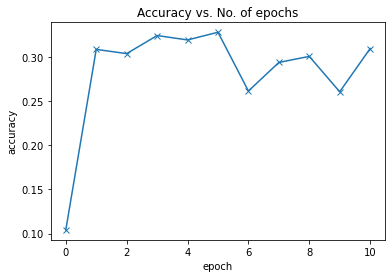

In [45]:
history_log = [result0] + history2 
accuracies = [result['val_acc'] for result in history_log] # getting validation accuracies from each epoch in history_log
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

# Testing

In [46]:
test_loader2 = DeviceDataLoader(DataLoader(test_set, batch_size*2), device)
result2 = evaluate2(model2, test_loader2)
result2

{'val_loss': 1.5946601629257202, 'val_acc': 0.4067284166812897}

# Hyperparameter Tuning for the CNN model

In [47]:
#history1 = fit(num_epochs, lr, model, train_dl2, val_dl2, torch.optim.SGD)

Epoch [0], train_loss: 0.3682, val_loss: 0.5044, val_acc: 0.8270
Epoch [1], train_loss: 0.3624, val_loss: 0.5056, val_acc: 0.8275
Epoch [2], train_loss: 0.3603, val_loss: 0.5067, val_acc: 0.8286
Epoch [3], train_loss: 0.3588, val_loss: 0.5069, val_acc: 0.8295
Epoch [4], train_loss: 0.3575, val_loss: 0.5050, val_acc: 0.8281
Epoch [5], train_loss: 0.3565, val_loss: 0.5084, val_acc: 0.8267
Epoch [6], train_loss: 0.3556, val_loss: 0.5088, val_acc: 0.8291
Epoch [7], train_loss: 0.3549, val_loss: 0.5085, val_acc: 0.8285
Epoch [8], train_loss: 0.3542, val_loss: 0.5063, val_acc: 0.8281
Epoch [9], train_loss: 0.3534, val_loss: 0.5049, val_acc: 0.8303


In [ ]:
# test_loader1 = DeviceDataLoader(DataLoader(test_set, batch_size*2), device)
# result1 = evaluate(model, test_loader1)
# result1